# Classifying handwritten digits from the MNIST dataset

## Fetching MNIST data

In [1]:
import os
import random
from six.moves import urllib
random.seed(42)    #42, Answer to the Ultimate Question of Life, the Universe, and Everything

In [2]:
URL = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
PATH = os.path.join('datasets', 'mnist')
def fetch_data(url=URL, path=PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    file_path = os.path.join(path, url.split('/')[-1])
    urllib.request.urlretrieve(url, file_path)
    return file_path
file_path = fetch_data()

## Loading data

In [3]:
import scipy.io
mnist = scipy.io.loadmat(file_path)

In [4]:
mnist['target'] = mnist.pop('label')    #to match the key name used when downlaoded by sklearn

In [5]:
import numpy as np
X, y = np.transpose(mnist['data']), np.reshape(mnist['target'], np.product(mnist['target'].shape),)

print("Data:", X.shape)
print("Target:", y.shape)

Data: (70000, 784)
Target: (70000,)


### Let's take a peek at one digit from the dataset

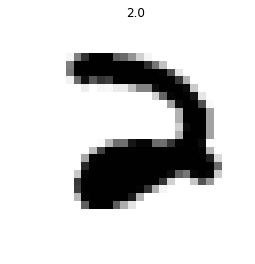

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

rand = random.randint(0, 69999)
some_digit = X[rand]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.title(y[rand])
plt.axis("off")
plt.show()

## Train-test split

### The MNIST dataset is actually already split (60,000 + 10,000)

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [16]:
#shuffling the training set
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier (simplifying the problem)

In [17]:
#creating a "5-detector"
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#running a Stochastic Gradient Descent Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/home/abandoned_greyhound/env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [18]:
sgd_clf.predict([X[36000]])    #image of a '5'

array([False])

## Performance Measures

### Cross-Validation

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/home/abandoned_greyhound/env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.96745


/home/abandoned_greyhound/env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9604


/home/abandoned_greyhound/env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9651


In [20]:
#using the cross_val_score() function
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

/home/abandoned_greyhound/env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/abandoned_greyhound/env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/h

array([0.96745, 0.9604 , 0.9651 ])